# Train Model

In [1]:
import logging
import os.path as path
import pickle
from dataclasses import dataclass

from haikunator import Haikunator

import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sklearn.preprocessing as skprep
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

from torchutils import Hyperparams, Trainer, TrainerArgs, evaluate
from torchutils.ml_loggers.csv_logger import CsvMLExperiment
from torchutils.ml_loggers.stdout_logger import StdoutMLExperiment
from torchutils.visualizers.csv_metrics_visualizer import analyze, compare

In [2]:
logging.basicConfig(level=logging.DEBUG)

In [3]:
DATAROOT = "~/mldata/bike-sharing"

In [40]:
class BikeDataFactory:
    def __init__(self) -> None:
        self._category_encoder = skprep.OneHotEncoder()
        self._numerical_scaler = skprep.StandardScaler()
        self.y_mean = float("inf")
        self.y_std = float("inf")
        self._is_fitted = False
        self._test_df = None
        
    def _features(self, df: pd.DataFrame) -> np.ndarray:
        df["year"] = df.index.year
        df["month"] = df.index.month
        df["dow"] = df.index.dayofweek
        df["hour"] = df.index.hour
        
        cat_flds = df[["year", "month", "dow", "hour", "season", "weather"]].values
        if not self._is_fitted:
            self._category_encoder.fit(cat_flds)
        encoded_cat_flds = self._category_encoder.transform(cat_flds).toarray()
        
        num_flds = df[["temp", "atemp", "humidity", "windspeed"]].values
        if not self._is_fitted:
            self._numerical_scaler.fit(num_flds)
        scaled_num_flds = self._numerical_scaler.transform(num_flds)
        
        X = df[["holiday", "workingday"]].values
        X = np.concatenate((X, encoded_cat_flds), axis=1)
        X = np.concatenate((X, scaled_num_flds), axis=1)
        
        return X
        
    def trainset(self, filepath: str) -> Dataset:
        train_df = pd.read_csv(filepath, parse_dates=["datetime"], index_col="datetime")
        
        X = self._features(train_df)
        
        self.y_mean = np.mean(train_df["count"].values)
        self.y_std = np.std(train_df["count"].values)
        y = (train_df["count"].values - self.y_mean) / self.y_std
        
        self._is_fitted = True
        
        return TensorDataset(t.from_numpy(X).to(t.float32), t.from_numpy(y).to(t.float32))
    
    def test_X(self, filepath: str) -> np.ndarray:
        if not self._is_fitted:
            raise RuntimeError("Cannot generate testset without generating trainset first!")
            
        self._test_df = pd.read_csv(filepath, parse_dates=["datetime"], index_col="datetime")
        return self._features(self._test_df)
    
    def create_submission(self, y_pred: np.ndarray, outpath: str) -> None:
        self._test_df["count"] = ((y_pred * self.y_std) + self.y_mean).to(t.int64).numpy()
        self._test_df[["count"]].to_csv(outpath)
        
        
        
class BikeDataFactoryWithLogCounts:
    def __init__(self) -> None:
        self._category_encoder = skprep.OneHotEncoder()
        self._numerical_scaler = skprep.StandardScaler()
        self._is_fitted = False
        self._test_df = None
        
    def _features(self, df: pd.DataFrame) -> np.ndarray:
        df["year"] = df.index.year
        df["month"] = df.index.month
        df["dow"] = df.index.dayofweek
        df["hour"] = df.index.hour
        
        cat_flds = df[["year", "month", "dow", "hour", "season", "weather"]].values
        if not self._is_fitted:
            self._category_encoder.fit(cat_flds)
        encoded_cat_flds = self._category_encoder.transform(cat_flds).toarray()
        
        num_flds = df[["temp", "atemp", "humidity", "windspeed"]].values
        if not self._is_fitted:
            self._numerical_scaler.fit(num_flds)
        scaled_num_flds = self._numerical_scaler.transform(num_flds)
        
        X = df[["holiday", "workingday"]].values
        X = np.concatenate((X, encoded_cat_flds), axis=1)
        X = np.concatenate((X, scaled_num_flds), axis=1)
        
        return X
        
    def trainset(self, filepath: str) -> Dataset:
        train_df = pd.read_csv(filepath, parse_dates=["datetime"], index_col="datetime")
        X = self._features(train_df)
        y = np.log(train_df["count"].values)
        self._is_fitted = True
        return TensorDataset(t.from_numpy(X).to(t.float32), t.from_numpy(y).to(t.float32))
    
    def test_X(self, filepath: str) -> np.ndarray:
        if not self._is_fitted:
            raise RuntimeError("Cannot generate testset without generating trainset first!")
            
        self._test_df = pd.read_csv(filepath, parse_dates=["datetime"], index_col="datetime")
        return self._features(self._test_df)
    
    def create_submission(self, y_pred: t.Tensor, outpath: str) -> None:
        y_pred = y_pred.detach().numpy()
        self._test_df["count"] = np.exp(y_pred).astype(np.int)
        self._test_df[["count"]].to_csv(outpath)        

In [41]:
data_factory = BikeDataFactoryWithLogCounts()

In [42]:
dataset = data_factory.trainset(path.join(DATAROOT, "train.csv"))

In [43]:
train_size = int(len(dataset) * 0.9)
val_size = len(dataset) - train_size
trainset, valset = random_split(dataset, (train_size, val_size))
print(len(trainset), len(valset))

9797 1089


## Train Model

In [44]:
h = Haikunator()

In [45]:
class BaselineRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(59, 1)
    
    def forward(self, batch_x):
        x1 = self.fc(batch_x)
        batch_y_hat = t.squeeze(x1, dim=1)
        return batch_y_hat

### Wire Check

In [46]:
batch_X, batch_y = trainset[:5]
tmp_model = BaselineRegressor()

In [47]:
batch_y_hat = tmp_model(batch_X)

In [48]:
print(batch_y_hat.dtype, batch_y_hat.shape)
batch_y_hat

torch.float32 torch.Size([5])


tensor([-0.3803, -0.0749, -0.1775, -0.4042, -0.4723],
       grad_fn=<SqueezeBackward1>)

In [49]:
batch_y

tensor([5.3660, 5.0626, 4.3694, 6.4345, 6.3421])

In [50]:
nn.MSELoss()(batch_y_hat, batch_y)

tensor(34.6586, grad_fn=<MseLossBackward>)

### Utility Functions

In [51]:
def rmsle(y_true, y_hat):
    y_true = y_true.detach().to(t.float64).numpy()
    y_hat = y_hat.detach().to(t.float64).numpy()
    
    # First de-normalize both y_true and y_hat
    y_true = (y_true * data_factory.y_std) + data_factory.y_mean
    y_pred = (y_hat * data_factory.y_std) + data_factory.y_mean
    
    # If there are negative values, then zero them out
    if (y_true < 0).any():
        print("[WARN]: y_true has negative values.")
        y_true[y_true < 0] = 0
    if (y_pred < 0).any():
        print("[WARN]: y_pred has negative values.")
        y_pred[y_pred < 0] = 0
    
    msle = mean_squared_log_error(y_true, y_pred)
    return np.sqrt(msle)


def rmse(y_true, y_hat):
    y_true = y_true.detach().to(t.float64).numpy()
    y_pred = y_hat.detach().to(t.float64).numpy()
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [52]:
err = rmse(batch_y, batch_y_hat)
print(err, type(err))

5.887156811872805 <class 'numpy.float64'>


In [53]:
model_factory = {
    "baseline": BaselineRegressor
}

In [54]:
@dataclass
class MyHyperparams(Hyperparams):
    batch_size: int
    n_epochs: int
    lr: float
    model_type: str

In [55]:
def build_trainer(hparams, trainset, valset):
    run_name = h.haikunate()
    print(f"Starting run {run_name}")
    model = model_factory[hparams.model_type]()
    optim = t.optim.Adam(model.parameters(), lr=hparams.lr)
    loss_fn = nn.MSELoss()
    traindl = DataLoader(trainset, batch_size=hparams.batch_size, shuffle=True)
    valdl = DataLoader(valset, batch_size=1089)
    return TrainerArgs(
        run_name=run_name,
        model=model,
        optim=optim,
        loss_fn=loss_fn,
        trainloader=traindl,
        valloader=valdl,
        n_epochs=hparams.n_epochs
    )

### Train Baseline Model

In [77]:
exp = CsvMLExperiment("bike-share-exp1", "~/temp/experiments", stdout=False)
trainer = Trainer(exp, trainset, valset, [rmse])
trainer.metrics_log_frequency = 1

In [98]:
hparams = MyHyperparams(batch_size=64, n_epochs=20, lr=0.003, model_type="baseline")
trainer.train(hparams, build_trainer)
trainer.final_metrics

Starting run old-base-2499


{'val_loss': 0.3818299174308777, 'val_rmse': 0.6179238546673153}

In [58]:
valdl = DataLoader(valset, batch_size=1089)
metrics = evaluate(trainer.model, valdl, [rmse])

In [59]:
metrics.keys()

dict_keys(['rmse', 'outputs', 'targets'])

In [60]:
outputs = metrics["outputs"]
targets = metrics["targets"]

In [61]:
print(outputs.shape, targets.shape)

torch.Size([1089]) torch.Size([1089])


In [62]:
targets[:10]

tensor([5.3845, 4.6347, 4.6821, 4.3175, 5.0370, 5.2523, 3.7842, 6.0753, 6.4831,
        1.3863])

In [63]:
outputs[:10]

tensor([5.5989, 4.8426, 4.9568, 4.7839, 5.2985, 5.0427, 4.9623, 6.0488, 6.6009,
        3.3246])

In [64]:
y_true = np.exp(targets)
y_true[:10]

tensor([218.0000, 103.0000, 108.0000,  75.0000, 154.0000, 191.0000,  44.0000,
        435.0000, 654.0002,   4.0000])

In [65]:
y_pred = np.exp(outputs)
y_pred[:10]

tensor([270.1267, 126.7985, 142.1392, 119.5729, 200.0455, 154.8869, 142.9171,
        423.5977, 735.7400,  27.7867])

Evaluation Metrics
  val_loss  : 0.385
  val_rmse  : 0.62


Hyper Parameters
  batch_size  : 64
  n_epochs    : 100
  lr          : 0.003
  model_type  : baseline


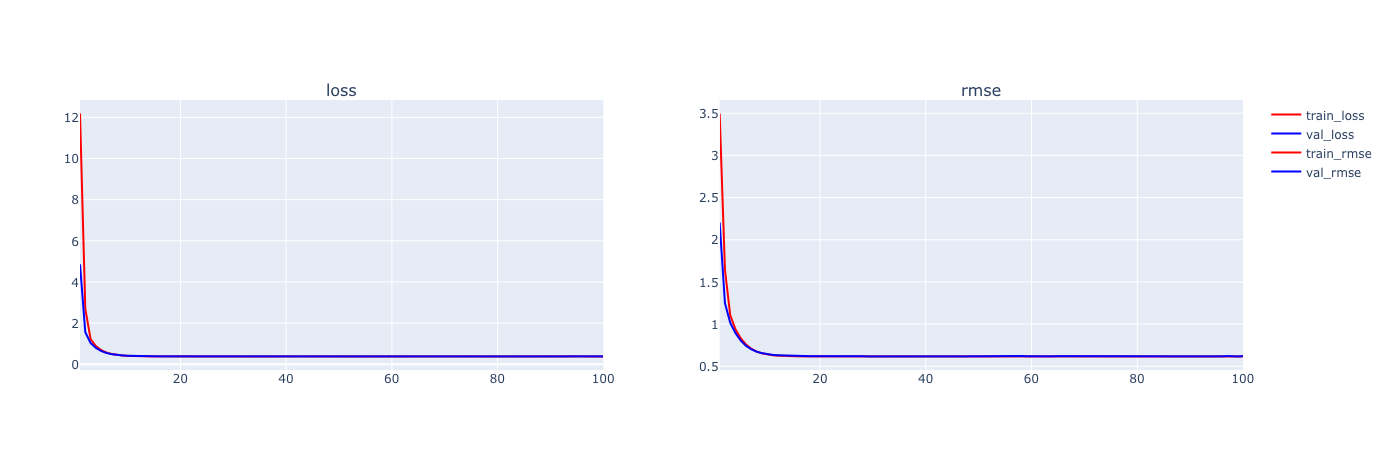

In [97]:
analyze(exproot="/Users/avilay/temp/experiments/bike-share-exp1", run_name="twilight-brook-3066")

In [155]:
df = compare("/Users/avilay/temp/experiments/bike-share-exp1")

To plot using this dataframe:
fig = go.Figure(layout_title_text='Loss', layout_xaxis_title='Runs'
fig.add_bar(x=summary.run_names, y=summary.val_loss)



In [158]:
df[(df.model_type == "mlp") | (df.model_type == "deepmlp")].sort_values(by="val_rmse")

,run_names,val_loss,val_rmse,batch_size,n_epochs,lr,model_type
2,silent-sunset-7568,0.095289,0.308689,32,15,0.001,mlp
27,throbbing-cake-8979,0.095915,0.309701,16,15,0.002,mlp
17,steep-river-8140,0.097709,0.312584,64,50,0.001,mlp
25,patient-star-8184,0.097844,0.312801,16,15,0.001,mlp
3,dry-moon-7664,0.100252,0.316626,32,15,0.003,mlp
21,raspy-cell-6140,0.100467,0.316966,32,20,0.003,mlp
6,old-bar-8596,0.102697,0.320463,64,15,0.001,mlp
16,soft-thunder-9758,0.105142,0.324256,64,20,0.003,mlp
0,square-shadow-0135,0.105596,0.324955,32,50,0.003,mlp
22,divine-feather-4952,0.108511,0.329411,32,15,0.003,mlp


## More Sophisticated Models

In [111]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(59, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, batch_x):
        x1 = F.relu(self.fc1(batch_x))
        x2 = self.fc2(x1)
        batch_y_hat = t.squeeze(x2, dim=1)
        return batch_y_hat

In [112]:
model_factory["mlp"] = MLP

In [162]:
exp = CsvMLExperiment("bike-share-exp1", "~/temp/experiments", stdout=False)
trainer = Trainer(exp, trainset, valset, [rmse])
trainer.metrics_log_frequency = 1

In [164]:
hparams = MyHyperparams(batch_size=32, n_epochs=15, lr=0.001, model_type="mlp")
trainer.train(hparams, build_trainer)
trainer.final_metrics

Starting run spring-queen-7218


{'val_loss': 0.09555015712976456, 'val_rmse': 0.3091118959071148}

Evaluation Metrics
  val_loss  : 0.112
  val_rmse  : 0.335


Hyper Parameters
  batch_size  : 32
  n_epochs    : 30
  lr          : 0.003
  model_type  : mlp


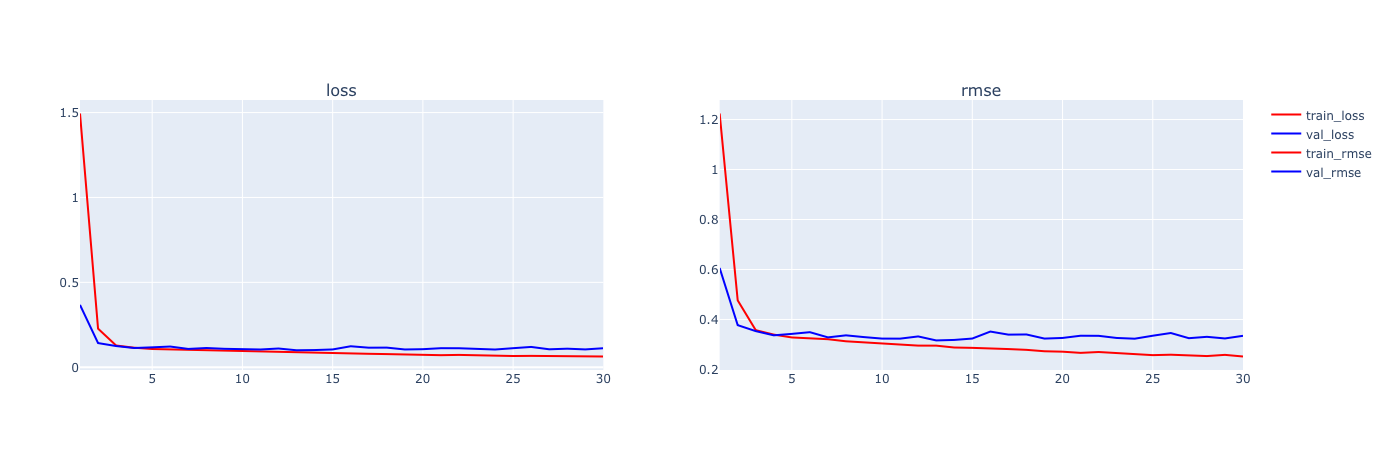

In [126]:
analyze(exproot="/Users/avilay/temp/experiments/bike-share-exp1", run_name="steep-block-0380")

In [135]:
class DeepMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(59, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, batch_x):
        x1 = F.relu(self.fc1(batch_x))
        x2 = F.relu(self.fc2(x1))
        x3 = self.fc3(x2)
        batch_y_hat = t.squeeze(x3, dim=1)
        return batch_y_hat

In [136]:
model_factory["deepmlp"] = DeepMLP

In [175]:
exp = CsvMLExperiment("bike-share-exp1", "~/temp/experiments", stdout=False)
trainer = Trainer(exp, trainset, valset, [rmse])
trainer.metrics_log_frequency = 1

In [195]:
hparams = MyHyperparams(batch_size=16, n_epochs=25, lr=0.0005, model_type="deepmlp")
trainer.train(hparams, build_trainer)
trainer.final_metrics

Starting run dry-rain-8654


{'val_loss': 0.09932097792625427, 'val_rmse': 0.3151523162150063}

Evaluation Metrics
  val_loss  : 0.11
  val_rmse  : 0.331


Hyper Parameters
  batch_size  : 16
  n_epochs    : 30
  lr          : 0.0
  model_type  : deepmlp


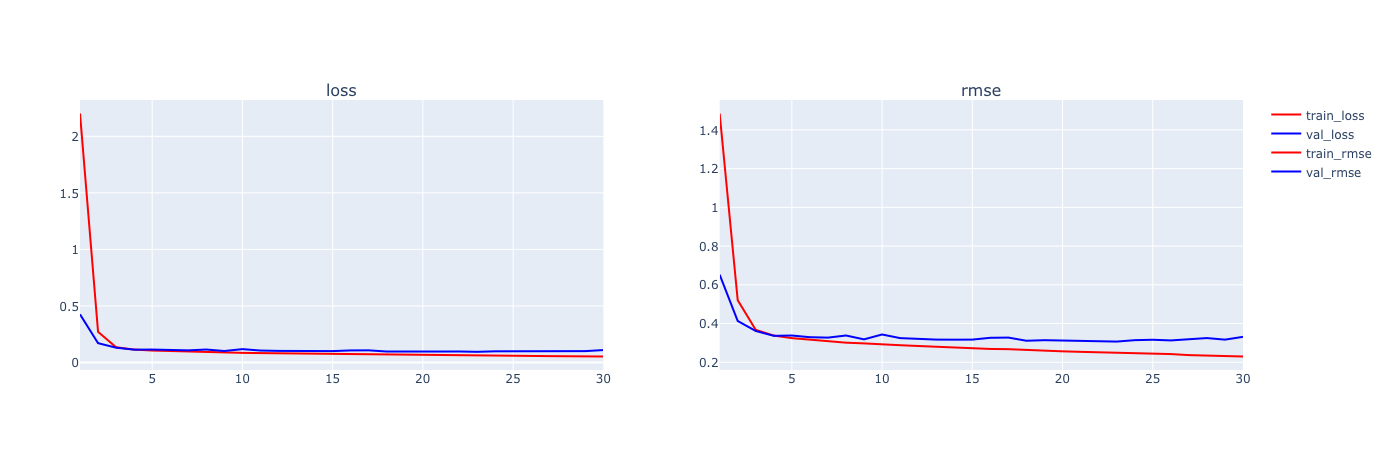

In [193]:
analyze(exproot="/Users/avilay/temp/experiments/bike-share-exp1", run_name="aged-queen-7579")

# Evaluate

In [196]:
exp = StdoutMLExperiment("eval")
final_trainer = Trainer(exp, dataset, valset, [rmse])
final_trainer.metrics_log_frequency = 5
hparams = MyHyperparams(batch_size=16, n_epochs=25, lr=0.0005, model_type="deepmlp")
final_trainer.train(hparams, build_trainer)
final_trainer.final_metrics

Starting run blue-morning-0337
Starting run blue-morning-0337

Step 5
	train_loss = 0.107
	train_rmse = 0.327
	val_loss = 0.099
	val_rmse = 0.315

Step 10
	train_loss = 0.090
	train_rmse = 0.300
	val_loss = 0.080
	val_rmse = 0.282

Step 15
	train_loss = 0.079
	train_rmse = 0.281
	val_loss = 0.065
	val_rmse = 0.255

Step 20
	train_loss = 0.071
	train_rmse = 0.267
	val_loss = 0.062
	val_rmse = 0.249

Summary:
{'evaluation_metrics': {'val_loss': 0.058, 'val_rmse': 0.241},
 'hyperparams': {'batch_size': 16,
                 'lr': 0.0005,
                 'model_type': 'deepmlp',
                 'n_epochs': 25}}

Step 25
	train_loss = 0.064
	train_rmse = 0.252
	val_loss = 0.058
	val_rmse = 0.241


{'val_loss': 0.057986993342638016, 'val_rmse': 0.24080488616542123}

In [197]:
test_X = data_factory.test_X(path.join(DATAROOT, "test.csv"))

In [198]:
test_y_pred = final_trainer.model(t.from_numpy(test_X).to(t.float32))

In [199]:
data_factory.create_submission(test_y_pred, path.join(DATAROOT, "deepmlp-submission.csv"))